# Регуляризации

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, SubsetRandomSampler

import torchvision
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize(0.5,0.5, 0.5)])
train_dataset = CIFAR10(root = '/cifar10', download=True,transform=train_transform, train=True)

Files already downloaded and verified


In [ ]:
valid_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.5,0.5, 0.5)])
valid_dataset = CIFAR10(root = '/cifar10', download=True,transform=valid_transform, train=True)

Files already downloaded and verified


In [ ]:
num_train = len(train_dataset)
indices = list(range(num_train))
split_idx = int(0.9*num_train)
np.random.seed(42)
np.random.shuffle(indices)
train_indices = indices[:split_idx]
valid_indices = indices[split_idx:]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

In [ ]:
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=False, sampler=train_sampler)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=64, shuffle=False, sampler=valid_sampler)

In [ ]:
transform_ = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.5,0.5, 0.5)])
test_dataset = CIFAR10(root = '/cifar10', download=True,transform=transform_, train=False)

Files already downloaded and verified


In [ ]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels=32, kernel_size=3)
        self.bn_1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.bn_2 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.bn_3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 3)
        self.bn_4 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 5 * 5, 150)
        self.fc2 = nn.Linear(150, 64)
        self.fc3 = nn.Linear(64, num_classes)


    def forward(self, x):
        x = F.leaky_relu(self.bn_1(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.bn_2(self.conv2(x))))
        x = F.dropout(F.leaky_relu(self.bn_3(self.conv3(x))))
        x = self.pool(F.leaky_relu(self.bn_4(self.conv4(x))))
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.softmax(self.fc3(x),dim=1)
        return x

In [ ]:
model = Net(10).cuda()
optimizer = optim.AdamW(params=model.parameters(), lr=0.0001, betas=(0.9,0.999))
criterion = nn.CrossEntropyLoss()

In [ ]:
#train_losses = []
#valid_losses = []
num_epochs=60
for epoch in range(50,num_epochs):
    epoch_train_losses = []
    epoch_valid_losses = []
    model.train()
    for images, labels in train_loader:
        images = images.cuda()
        labels = labels.cuda()

        model.zero_grad()
        pred = model(images)
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        epoch_train_losses.append(loss.item())

    model.eval()
    for images, labels in valid_loader:
        images = images.cuda()
        labels = labels.cuda()

        pred = model(images)
        loss = criterion(pred, labels)
        valid_losses.append(loss.item())
        epoch_valid_losses.append(loss.item())

    print("Epoch [{}/{}], Train Loss: {}, Valid Loss: {}".format(epoch+1, num_epochs,
                                           sum(epoch_train_losses)/len(epoch_train_losses),
                                           sum(epoch_valid_losses)/len(epoch_valid_losses)))

In [ ]:
torch.save(model, 'model_50.pt')


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


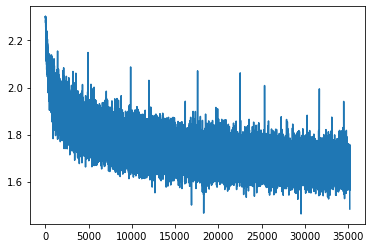

In [ ]:
plt.plot(train_losses)

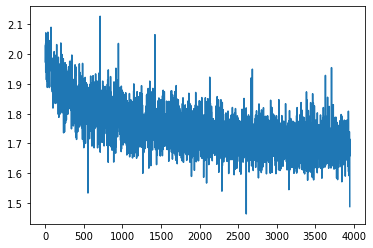

In [ ]:
plt.plot(valid_losses)

In [ ]:
model2 = torch.load('model_50.pt')
model2.eval()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn_3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn_4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1600, out_features=150, bias=True)
  (fc2): Linear(in_features=150, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [ ]:
test_dataloader = DataLoader(dataset=test_dataset, batch_size=64)
model.eval()
model2.eval()
result = 0
for images, labels in test_dataloader:
    images = images.cuda()
    labels = labels.cuda()
    pred1 = model(images)
    pred2 = model2(images)
    prediction = torch.argmax((pred1+pred2)/2,1)
    res = torch.eq(prediction.cpu(),labels.cpu()).sum()
    result+=res.item()
print('Result: {}%'.format(result/len(test_dataset)*100)) 

Result: 78.49000000000001%


# Перенос обучения

In [ ]:
from torchvision.models import resnet50
import torchvision.datasets as datasets
import os

In [ ]:
! wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

--2020-05-25 17:55:47--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.86.38.37, 99.86.38.96, 99.86.38.106, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.38.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  89.3MB/s    in 0.5s    

2020-05-25 17:55:48 (89.3 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train

In [ ]:
print(os.getcwd())
print(os.listdir(os.path.join(os.getcwd(),r'hymenoptera_data/','train','ants')))

/content
['450057712_771b3bfc91.jpg', '226951206_d6bf946504.jpg', '466430434_4000737de9.jpg', '543417860_b14237f569.jpg', 'MehdiabadiAnt2_600.jpg', '6240338_93729615ec.jpg', '150801003_3390b73135.jpg', '245647475_9523dfd13e.jpg', '2019439677_2db655d361.jpg', 'Nepenthes_rafflesiana_ant.jpg', '424873399_47658a91fb.jpg', '1225872729_6f0856588f.jpg', '342438950_a3da61deab.jpg', '1368913450_e146e2fb6d.jpg', '201790779_527f4c0168.jpg', '535522953_308353a07c.jpg', '541630764_dbd285d63c.jpg', '386190770_672743c9a7.jpg', '938946700_ca1c669085.jpg', 'imageNotFound.gif', 'kurokusa.jpg', '154124431_65460430f2.jpg', 'army-ants-red-picture.jpg', '175998972.jpg', '382971067_0bfd33afe0.jpg', '132478121_2a430adea2.jpg', '339670531_94b75ae47a.jpg', '957233405_25c1d1187b.jpg', '20935278_9190345f6b.jpg', '2292213964_ca51ce4bef.jpg', '188552436_605cc9b36b.jpg', '2265825502_fff99cfd2d.jpg', '374435068_7eee412ec4.jpg', '275429470_b2d7d9290b.jpg', '540889389_48bb588b21.jpg', '7759525_1363d24e88.jpg', '2079479

In [ ]:
train_transforms = transforms.Compose([     
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ])

val_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = 'hymenoptera_data'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                          train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'),
                                          val_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True,
                              num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=True,
                              num_workers=4)

train_dataset_len = len(train_dataset)
val_dataset_len = len(val_dataset)

class_names = train_dataset.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

In [ ]:
inputs, classes = next(iter(train_dataloader))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
model = resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [ ]:
print(model)

In [ ]:
#признаки предпоследнего слоя
num_features = model.fc.in_features
print(num_features)

2048


In [ ]:
model.fc = nn.Linear(num_features, 2)

In [ ]:
print(model)

In [ ]:
criterion = nn.CrossEntropyLoss()
model.cuda()

Обучение только последнего слоя при "замороженных" весах всех предыдущих

In [ ]:
optimizer = optim.AdamW(params=model.fc.parameters())

Обучение всей модели

In [ ]:
optimizer = optim.AdamW(params=model.parameters())

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
train_losses = []
val_losses = []
num_epochs=2
for epoch in range(0,num_epochs):
    epoch_train_losses = []
    epoch_val_losses = []

    model.train()
    for images, labels in train_dataloader:
        images = images.cuda()
        labels = labels.cuda()

        model.zero_grad()
        pred = model(images)
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        epoch_train_losses.append(loss.item())
        
    model.eval()
    for images, labels in val_dataloader:
        images = images.cuda()
        labels = labels.cuda()

        pred = model(images)
        loss = criterion(pred, labels)
        val_losses.append(loss.item())
        epoch_val_losses.append(loss.item())

    print("Epoch [{}/{}], Train Loss: {}, Valid Loss: {}".format(epoch+1, num_epochs,
                                           sum(epoch_train_losses)/len(epoch_train_losses),
                                           sum(epoch_val_losses)/len(epoch_val_losses)))

Epoch [1/2], Train Loss: 1.2477202515621655, Valid Loss: 2.324901353090237
Epoch [2/2], Train Loss: 0.7371650069463448, Valid Loss: 0.6940747591165396


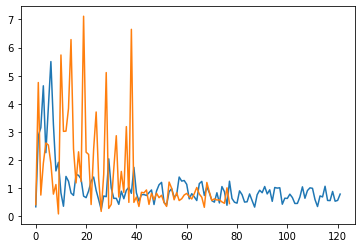

In [ ]:
plt.plot(train_losses)
plt.plot(val_losses)

In [ ]:
model.eval()
result = 0
for images, labels in val_dataloader:
    images = images.cuda()
    labels = labels.cuda()
    pred1 = model(images)
    #pred2 = model2(images)
    prediction = torch.argmax(pred1,1)
    res = torch.eq(prediction.cpu(),labels.cpu()).sum()
    result+=res.item()
print('Result: {}%'.format(result/len(val_dataset)*100)) 

Result: 58.16993464052288%


# Аугментации

In [ ]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "All libraries are successfully installed!"
  
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/8/8a/Dryocopus_pileatus_MP2.jpg/600px-Dryocopus_pileatus_MP2.jpg -q -O example.jpg

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-ls1kvhdf
All libraries are successfully installed!


In [ ]:
import numpy as np
import random
import cv2
from matplotlib import pyplot as plt
from IPython.display import display, HTML 

import albumentations as A

In [ ]:
def show_img(img, figsize=(8, 8)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.grid(False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.imshow(img)
    plt.imshow(img)

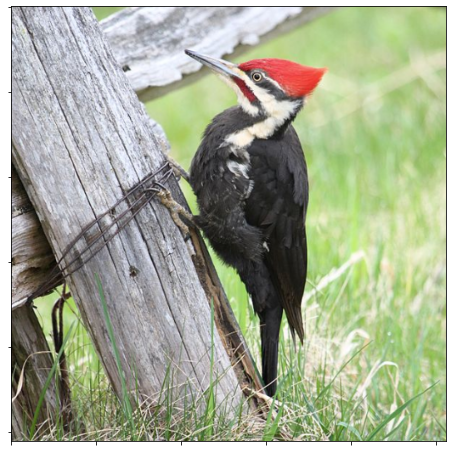

In [ ]:
image = cv2.imread('example.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (512, 512))

show_img(image)

In [ ]:
augmentation = A.RandomBrightness(limit=0.7, p=0.5)

In [ ]:
random.seed(42)

light = A.Compose([
    A.RandomBrightnessContrast(p=1),    
    A.RandomGamma(p=1),    
    A.CLAHE(p=1),    
], p=1)

medium = A.Compose([
    A.CLAHE(p=1),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=50, val_shift_limit=50, p=1),
], p=1)


strong = A.Compose([
    A.ChannelShuffle(p=1),
], p=1)

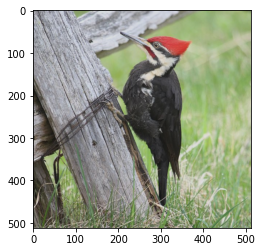

In [ ]:
augmentation = A.Compose([A.RandomBrightnessContrast(p=1),A.RandomGamma(p=1)],p=1)
aug_image = augmentation(image=image)['image']
fig1 = plt.figure()
ax = fig1.add_subplot(111)
ax.imshow(aug_image)

![HSV](https://)


![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/3/33/HSV_color_solid_cylinder_saturation_gray.png/1024px-HSV_color_solid_cylinder_saturation_gray.png)

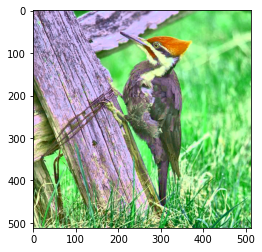

In [ ]:
augmentation = A.Compose([
    A.CLAHE(p=1),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=50, val_shift_limit=50, p=1),
], p=1)
aug_image = augmentation(image=image)['image']
fig1 = plt.figure()
ax = fig1.add_subplot(111)
ax.imshow(aug_image)

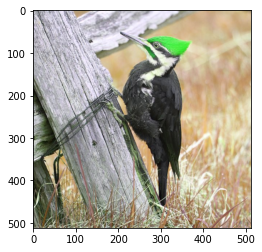

In [ ]:
augmentation = A.Compose([
    A.ChannelShuffle(p=1)
], p=1)
aug_image = augmentation(image=image)['image']
fig1 = plt.figure()
ax = fig1.add_subplot(111)
ax.imshow(aug_image)

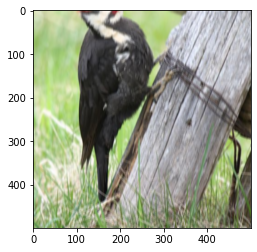

In [ ]:
augmentation = A.Compose([
    A.HorizontalFlip(p=1),
    A.RandomSizedCrop((400 - 100, 400 + 100), 500, 500),
    A.MotionBlur(blur_limit=17, p=1),
], p=1)
aug_image = augmentation(image=image)['image']
fig1 = plt.figure()
ax = fig1.add_subplot(111)
ax.imshow(aug_image)

In [ ]:
augmentation = A.RandomSunFlare(p=1, flare_roi=(0, 0, 1, 0.5), angle_lower=0.5)
aug_image = augmentation(image=image)['image']
fig1 = plt.figure()
ax = fig1.add_subplot(111)
ax.imshow(aug_image)

AttributeError: ignored

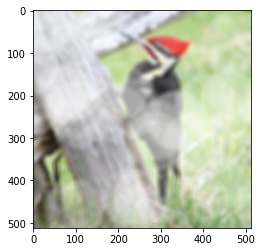

In [ ]:
augmentation = A.RandomFog(p=1, fog_coef_lower=0.7, fog_coef_upper=0.9, alpha_coef=0.3)
aug_image = augmentation(image=image)['image']
fig1 = plt.figure()
ax = fig1.add_subplot(111)
ax.imshow(aug_image)

# Домашнее задание

**Задача 1** Какие должны быть параметры свертки, чтобы изображение после сверточного слоя имело те же размеры, что и до него:
1. для слоя с ядром 1x1
2. для слоя с ядром 3x3
3. для слоя с ядром 5x5

**Задача 2** Напишите ядро свертки, которое
1. меняет местами красный и синий каналы
2. оставляет только красный и зеленый каналы

**Задача 3** Для детасета с изображениями насекомых напишите и обучите классификатор с точностью 95 %



**Задача 4** Отличается ли выход предпоследнего слоя в resnet, предобученной на ImageNet для разных объектов? Отличается ли он для разных изображений одного и того же объекта? Как можно это использовать?